FETCHREACH — PETS NOTEBOOK 

🔵 CELL 1 — Install

In [3]:
# !pip install gymnasium gymnasium-robotics numpy matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement gymnasium (from versions: none)
ERROR: No matching distribution found for gymnasium


🔵 CELL 2 — Imports

In [1]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
# import sys
# print(sys.version)


🔵 CELL 3 — Environment

In [3]:
env = gym.make("FetchReach-v4")
obs_dim = env.observation_space["observation"].shape[0]
act_dim = env.action_space.shape[0]


🔵 CELL 4 — Dynamics Model (Ensemble Member)

In [4]:
class DynamicsModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, obs_dim)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.net(x)


🔵 CELL 5 — Ensemble Initialization

In [5]:
ENSEMBLE_SIZE = 5
models = [DynamicsModel(obs_dim, act_dim) for _ in range(ENSEMBLE_SIZE)]
optimizers = [optim.Adam(m.parameters(), lr=1e-3) for m in models]


🔵 CELL 6 — Collect Random Dataset

In [6]:
dataset = []

obs, info = env.reset()

for _ in range(20_000):
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(action)

    dataset.append((
        obs["observation"],
        action,
        next_obs["observation"]
    ))

    obs = next_obs
    if terminated or truncated:
        obs, info = env.reset()

print("Dataset size:", len(dataset))


Dataset size: 20000


🔵 CELL 7 — Train Ensemble (PETS Core)

In [7]:
def train_ensemble(models, optimizers, dataset, epochs=5):
    for epoch in range(epochs):
        np.random.shuffle(dataset)
        losses = []

        for obs, act, next_obs in dataset:
            obs = torch.tensor(obs, dtype=torch.float32)
            act = torch.tensor(act, dtype=torch.float32)
            target = torch.tensor(next_obs, dtype=torch.float32)

            for model, opt in zip(models, optimizers):
                pred = model(obs.unsqueeze(0), act.unsqueeze(0)).squeeze(0)
                loss = ((pred - target) ** 2).mean()

                opt.zero_grad()
                loss.backward()
                opt.step()

                losses.append(loss.item())

        print(f"Epoch {epoch+1}, Loss: {np.mean(losses):.6f}")


In [8]:
train_ensemble(models, optimizers, dataset)

Epoch 1, Loss: 0.000260
Epoch 2, Loss: 0.000042
Epoch 3, Loss: 0.000028
Epoch 4, Loss: 0.000020
Epoch 5, Loss: 0.000017


🔵 CELL 8 — MPC Action Selection (Simplified PETS)

In [9]:
def select_action(obs, models, horizon=5, n_candidates=100):
    obs = torch.tensor(obs, dtype=torch.float32)

    best_action = None
    best_cost = float("inf")

    for _ in range(n_candidates):
        actions = torch.randn(horizon, act_dim).clamp(-1, 1)
        sim_obs = obs.clone()

        cost = 0
        for t in range(horizon):
            model = np.random.choice(models)
            sim_obs = model(sim_obs.unsqueeze(0), actions[t].unsqueeze(0)).squeeze(0)
            cost += torch.norm(sim_obs)

        if cost < best_cost:
            best_cost = cost
            best_action = actions[0]

    return best_action.numpy()


🔵 CELL 9 — Evaluation Rollout (Human)

In [10]:
eval_env = gym.make("FetchReach-v4", render_mode="human")

obs, info = eval_env.reset()
distances = []

for step in range(300):
    action = select_action(obs["observation"], models)
    obs, reward, terminated, truncated, info = eval_env.step(action)

    dist = np.linalg.norm(obs["achieved_goal"] - obs["desired_goal"])
    distances.append(dist)

    print(f"{step:03d} | distance={dist:.4f}")

    time.sleep(0.01)

    if terminated or truncated:
        obs, info = eval_env.reset()

eval_env.close()


000 | distance=0.0939
001 | distance=0.0887
002 | distance=0.1058
003 | distance=0.1251
004 | distance=0.1563
005 | distance=0.1886
006 | distance=0.2241
007 | distance=0.2594
008 | distance=0.2882
009 | distance=0.3033
010 | distance=0.3265
011 | distance=0.3647
012 | distance=0.3927
013 | distance=0.4310
014 | distance=0.4742
015 | distance=0.5107
016 | distance=0.5330
017 | distance=0.5754
018 | distance=0.5997
019 | distance=0.6280
020 | distance=0.6485
021 | distance=0.6448
022 | distance=0.6674
023 | distance=0.6682
024 | distance=0.6992
025 | distance=0.7283
026 | distance=0.7708
027 | distance=0.7569
028 | distance=0.7948
029 | distance=0.8358
030 | distance=0.8664
031 | distance=0.8720
032 | distance=0.8706
033 | distance=0.9058
034 | distance=0.9175
035 | distance=0.9285
036 | distance=0.9452
037 | distance=0.9701
038 | distance=0.9956
039 | distance=1.0112
040 | distance=1.0445
041 | distance=1.0817
042 | distance=1.0929
043 | distance=1.0513
044 | distance=1.0720
045 | dist

🔵 CELL 10 — Distance Plot

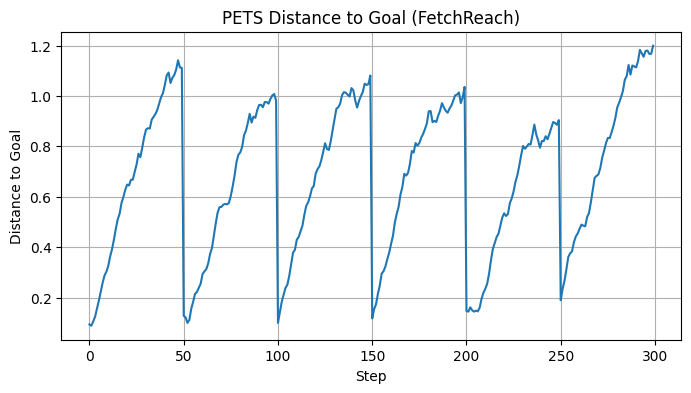

In [11]:
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.xlabel("Step")
plt.ylabel("Distance to Goal")
plt.title("PETS Distance to Goal (FetchReach)")
plt.grid(True)
plt.show()


🔵 CELL 11 — Formal Evaluation (100 Episodes)

In [12]:
eval_env = gym.make("FetchReach-v4")

episode_success = []
final_distances = []

for ep in range(100):
    obs, info = eval_env.reset()
    done = False

    while not done:
        action = select_action(obs["observation"], models)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated

    episode_success.append(info.get("is_success", 0))
    final_distances.append(
        np.linalg.norm(obs["achieved_goal"] - obs["desired_goal"])
    )


🔵 CELL 12 — Metrics

In [13]:
print(f"Success Rate: {np.mean(episode_success)*100:.2f}%")
print("Mean Final Distance:", np.mean(final_distances))
print("Final Distance Std:", np.std(final_distances))


Success Rate: 0.00%
Mean Final Distance: 1.046045715528754
Final Distance Std: 0.10956718705936631
